In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

/tmp/ipykernel_11786/2053087329.py:9: RuntimeWarning: overflow encountered in exp
  l2 = 2*h*nu**3/c/c/np.exp(h*nu/k/T)*1e6
/tmp/ipykernel_11786/2053087329.py:10: RuntimeWarning: overflow encountered in exp
  le = (2*h*nu**3/c**2)/(np.exp(h*nu/k/T)-1)*1e6


<IPython.core.display.Javascript object>


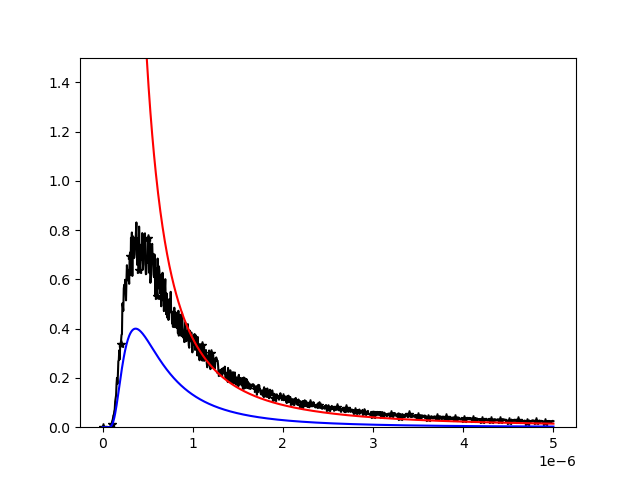

In [79]:
lam = np.linspace(0.0001, 5000, 1000) * 1e-9
k = 1.5e-23
T = 12000
c = 3e8
h = 6.6e-34
nu = c/lam

l1 = 2*k*T/lam/lam*1e6
l2 = 2*h*nu**3/c/c/np.exp(h*nu/k/T)*1e6
le = (2*h*nu**3/c**2)/(np.exp(h*nu/k/T)-1)*1e6
le = le*(1 + (1-np.random.rand(len(le))*0.5))
mx = np.sin(lam*1e7/5)**2
#le = l1*mx + (1-mx)*l2

lam_idx = np.arange(0, 1000, 20)

plt.figure()
plt.plot(lam, le, 'k')
plt.plot(lam[lam_idx], le[lam_idx], '*k')
plt.plot(lam, l1, 'r')
plt.plot(lam, l2, 'b')
plt.ylim([0, 1.5])
plt.show()


Epoch 0, Loss: 2.59200e+25
Epoch 100, Loss: 4.47655e-03
Epoch 200, Loss: 1.83408e-03
Epoch 300, Loss: 1.38178e-03
Epoch 400, Loss: 1.29295e-03
Epoch 500, Loss: 1.22051e-03
Epoch 600, Loss: 1.17817e-03
Epoch 700, Loss: 1.13616e-03
Epoch 800, Loss: 1.09028e-03
Epoch 900, Loss: 1.03984e-03


<IPython.core.display.Javascript object>


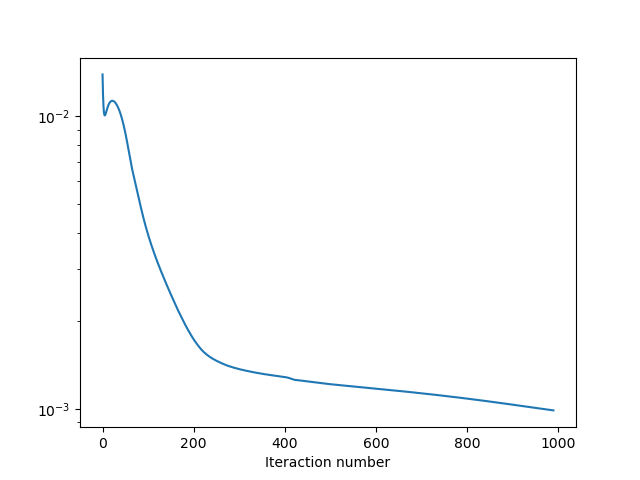

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the mixing network as a neural network
class MixingNetwork(nn.Module):
    def __init__(self):
        super(MixingNetwork, self).__init__()
        # Define the layers of the neural network
        self.fc1 = nn.Linear(2, 1000)
        self.fc2 = nn.Linear(1000, 1)
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        # Define the forward pass of the neural network
        x = torch.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

# Define the observed data
d = torch.tensor(le, dtype=torch.float32)

# Instantiate the physical theory networks and the mixing network
mixer = MixingNetwork()

# Define the loss function and the optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(mixer.parameters(), lr=0.001)
xmin_idx = 0
loss_list = []

# Train the mixing network
for epoch in range(1000):
    # Evaluate the predictions of the physical theory networks
    t12_pred = torch.tensor(np.array([l1, l2]).T, dtype=torch.float32)

    # Combine the predictions using the mixing network
    t1_weight = mixer(t12_pred)
    t2_weight = 1 - t1_weight
    combined_pred = t1_weight[xmin_idx:, 0] * t12_pred[xmin_idx:, 0] + t2_weight[xmin_idx:, 0] * t12_pred[xmin_idx:, 1]

    # Compute the loss and update the mixing network
    loss = criterion(combined_pred[lam_idx], d[xmin_idx:][lam_idx])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_list.append(loss.item())

    # Print the loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5e}")

plt.figure()
plt.semilogy(loss_list[10:])
plt.xlabel('Iteraction number')
plt.show()

<IPython.core.display.Javascript object>


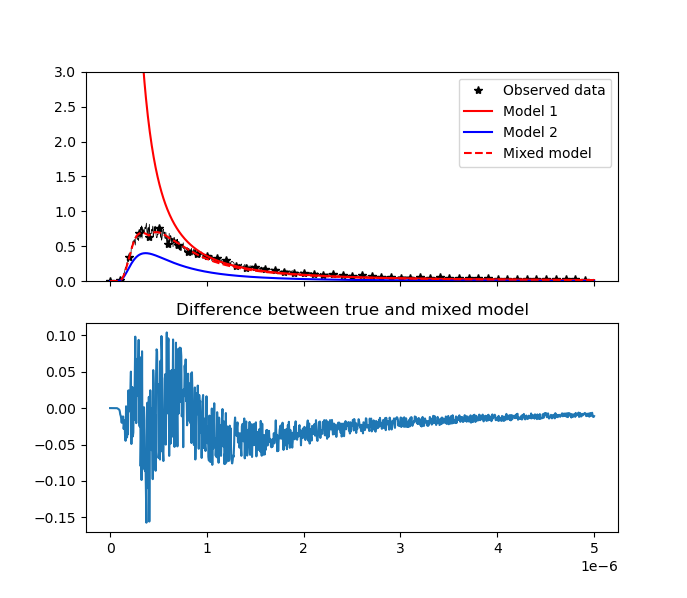

In [81]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
axs = axs.flatten()
axs[0].plot(lam[lam_idx], le[lam_idx], '*k', label='Observed data')
axs[0].plot(lam, le, 'k', lw=0.5)
axs[0].plot(lam, l1, 'r', label='Model 1')
axs[0].plot(lam, l2, 'b',label='Model 2')
axs[0].plot(lam[xmin_idx:], combined_pred.detach().numpy(), '--r', label='Mixed model')
axs[0].set_ylim([0, 3.0])
axs[0].legend()

axs[1].plot(lam, combined_pred.detach().numpy() - le)
axs[1].set_title('Difference between true and mixed model')
fig.show()
